In [1]:
import chainer
import chainer.functions as F
from chainer import initializers
import numpy as np
from chainer.utils import type_check
import matplotlib.pyplot as plt

In [2]:
# Adjust from chainer.linear to make it work with 1-d input

def _as_mat(x):
    if x.ndim == 2:
        return x
    return x.reshape(len(x), -1)


class LinearFunction(chainer.function.Function):

    def check_type_forward(self, in_types):
        n_in = in_types.size()
        type_check.expect(2 <= n_in, n_in <= 3)
        x_type, w_type = in_types[:2]

        type_check.expect(
            x_type.dtype.kind == 'f',
            w_type.dtype.kind == 'f',
#             x_type.ndim >= 2,
#             w_type.ndim == 2,
            type_check.prod(x_type.shape[1:]) == w_type.shape[1],
        )
        if type_check.eval(n_in) == 3:
            b_type = in_types[2]
            type_check.expect(
                b_type.dtype == x_type.dtype,
                b_type.ndim == 1,
                b_type.shape[0] == w_type.shape[0],
            )

    def forward(self, inputs):
        x = _as_mat(inputs[0])
        W = inputs[1]

        if not type_check.same_types(*inputs):
            raise ValueError('numpy and cupy must not be used together\n'
                             'type(W): {0}, type(x): {1}'
                             .format(type(W), type(x)))

        y = x.dot(W.T).astype(x.dtype, copy=False)
        if len(inputs) == 3:
            b = inputs[2]
            y += b
        return y,

    def backward(self, inputs, grad_outputs):
        x = _as_mat(inputs[0])
        W = inputs[1]
        gy = grad_outputs[0]

        if not type_check.same_types(*inputs):
            raise ValueError('numpy and cupy must not be used together\n'
                             'type(W): {0}, type(x): {1}'
                             .format(type(W), type(x)))

        gx = gy.dot(W).astype(x.dtype, copy=False).reshape(inputs[0].shape)
        gW = gy.T.dot(x).astype(W.dtype, copy=False)
        if len(inputs) == 3:
            gb = gy.sum(0)
            return gx, gW, gb
        else:
            return gx, gW


def linear(x, W, b=None):
    if b is None:
        return LinearFunction()(x, W)
    else:
        return LinearFunction()(x, W, b)

In [3]:
# Define linear layer using chainer.Link

class LinearLayer(chainer.Link):
    def __init__(self, n_in, n_out):
        super(LinearLayer, self).__init__()
        with self.init_scope():
            self.W = chainer.Parameter(
                initializers.Normal(), (n_out, n_in))
            self.b = chainer.Parameter(
                initializers.Zero(), (n_out,))

    def __call__(self, x):
        return linear(x, self.W, self.b)

In [4]:
# Parameters
learning_rate = 0.01
training_epochs = 1000
display_step = 50

In [5]:
# Training Data
train_X = np.asarray([3.3,4.4,5.5,6.71,6.93,4.168,9.779,6.182,7.59,2.167,
                         7.042,10.791,5.313,7.997,5.654,9.27,3.1], dtype=np.float32)
train_Y = np.asarray([1.7,2.76,2.09,3.19,1.694,1.573,3.366,2.596,2.53,1.221,
                         2.827,3.465,1.65,2.904,2.42,2.94,1.3], dtype=np.float32)
n_samples = train_X.shape[0]

Epoch  0050  loss=0.107259378    W=0.350252032    b=0.099650331
Epoch  0100  loss=0.103790462    W=0.344441414    b=0.140845045
Epoch  0150  loss=0.100718282    W=0.338973135    b=0.179612607
Epoch  0200  loss=0.097997464    W=0.333827049    b=0.216095939
Epoch  0250  loss=0.095587842    W=0.328984231    b=0.250429571
Epoch  0300  loss=0.093453795    W=0.324426711    b=0.282740265
Epoch  0350  loss=0.091563821    W=0.320137739    b=0.313147157
Epoch  0400  loss=0.089890026    W=0.316101491    b=0.341762364
Epoch  0450  loss=0.088407636    W=0.312303066    b=0.368691564
Epoch  0500  loss=0.087094806    W=0.308728397    b=0.394034147
Epoch  0550  loss=0.085932121    W=0.305364400    b=0.417883426
Epoch  0600  loss=0.084902391    W=0.302198619    b=0.440327585
Epoch  0650  loss=0.083990462    W=0.299219340    b=0.461449295
Epoch  0700  loss=0.083182812    W=0.296415627    b=0.481326371
Epoch  0750  loss=0.082467549    W=0.293777108    b=0.500032246
Epoch  0800  loss=0.081834070    W=0.291

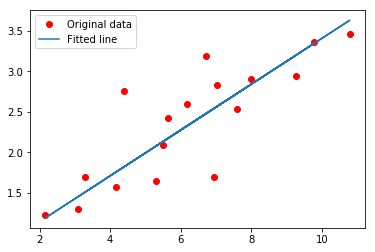

In [6]:
X = _as_mat(chainer.Variable(train_X)) # _as_mat reshape X from array (n_samples,) to matrix (n_samples, 1)
Y = _as_mat(chainer.Variable(train_Y)) # _as_mat reshape Y from array (n_samples,) to matrix (n_samples, 1)

# Define optimizer, here use SGD
opt = chainer.optimizers.SGD(lr=learning_rate)
li_reg = LinearLayer(1, 1)
opt.setup(li_reg)

for e in range(training_epochs):
    # clear grads of previous epochs after update
    li_reg.cleargrads()
    # Do forward
    h = li_reg(X)
    # Compute mean square error
    loss = F.sum(F.squared_error(h, Y) / (2*n_samples))
    # Back proppagation
    loss.backward()
    # Update grads
    opt.update()
    
    if (e + 1) % display_step == 0:
        print 'Epoch ', '%04d' % (e+1),' loss=%.9f' % loss.data, \
                '   W=%.9f' % li_reg.W.data, '   b=%.9f'% li_reg.b.data
            
print 'Optimisation finished!'

# Graphic display
plt.plot(train_X, train_Y, 'ro', label='Original data')
plt.plot(train_X, linear(train_X, li_reg.W, li_reg.b).data, label='Fitted line')
plt.legend()
plt.show()